In [3]:
# install matplotlib
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 21.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import sys

import pandas as pd
import numpy as np
import s3fs
import zipfile

sys.path.insert(0, 'datasets/')
import dataset
import roomsetup
import treatedroom
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download the data if not done
else skip that part

In [5]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [8]:
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [9]:
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [10]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/HC3.zip')

[None]

In [11]:
# Décompresser les données
with zipfile.ZipFile("data/HC3.zip","r") as zip_file:
    zip_file.extractall("data/")

### Implementing VGGish multichannel method

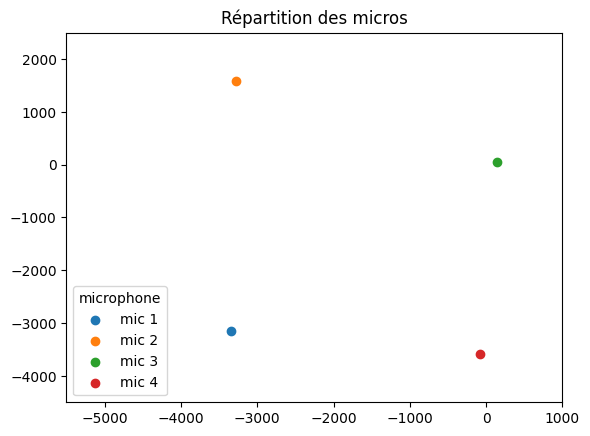

In [16]:
import numpy as np

# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4


mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4


walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000


## affichier la disposition des microphones.
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

In [50]:
# Loading the data

Human1_train = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy') 
Human2_train = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')

In [51]:
print(Human1_train.shape)
print(Human2_train.shape)
print(Human1_train[0].shape)

(1000, 4, 667200)
(104, 4, 667200)
(4, 667200)


In [29]:
### For VGGish mutlichannel, we need to modify the VGGish's CNN
### In order to pursue that, we need to use keras

### First we import the vggish model
### We follow the steps that are here https://github.com/tensorflow/models/blob/master/research/audioset/vggish/README.md
!git clone https://github.com/tensorflow/models.git

### $ cd models/research/audioset/vggish
#### Download data files into same directory as code.
### $ curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
### $ curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz
### $ pip install -r requirements.txt
#### test of the installation
### $ python vggish_smoke_test.py


### To use the model we need to do that 
#vggish_model_path = 'vggish/vggish_model.h5'
#vggish_model = tf.keras.models.load_model(vggish_model_path)


fatal: destination path 'models' already exists and is not an empty directory.


In [54]:
# setting up to modify the vggish architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization

#n_samples = data.shape[2]
#input_shape = (4, n_samples)

In [66]:
vggish_multi_model = Sequential()

vggish_multi_model.add(Conv1D(32, kernel_size=2, activation='relu', padding='same', input_shape=Human1_train[0].shape))
vggish_multi_model.add(MaxPooling1D(pool_size=2, padding='same'))
vggish_multi_model.add(Conv1D(32, kernel_size=2, activation='relu'))
vggish_multi_model.add(BatchNormalization())
vggish_multi_model.add(Dropout(0.4))

vggish_multi_model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
vggish_multi_model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
vggish_multi_model.add(MaxPooling1D(pool_size=2, padding='same'))
vggish_multi_model.add(BatchNormalization())
vggish_multi_model.add(Dropout(0.4))

vggish_multi_model.add(Conv1D(256, kernel_size=2, activation='relu', padding='same'))
vggish_multi_model.add(BatchNormalization())
vggish_multi_model.add(Dropout(0.4))


vggish_multi_model.add(Flatten())
vggish_multi_model.add(Dense(256, activation='relu'))
vggish_multi_model.add(Dropout(0.4))
vggish_multi_model.add(Dense(128, activation='relu'))
vggish_multi_model.add(Dropout(0.4))
vggish_multi_model.add(Dense(11, activation='softmax'))



vggish_multi_model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',      
              metrics=['accuracy'])

In [67]:
vggish_multi_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 4, 32)          │    42,700,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 1, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 1, 256)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,849,867 (163.46 MB)

 Trainable params: 42,849,163 (163.46 MB)

 Non-trainable params: 704 (2.75 KB)